In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Fig utils 
from fig_utils import (get_decile_score, 
                       deciles, 
                       AR_color,
                       Other_color,
                       AD_color)


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Load DD/ID gene sets

## Developmental Delay genes from Gene to Phenotype 
### G2P: https://www.ebi.ac.uk/gene2phenotype/
#### downloads: https://www.ebi.ac.uk/gene2phenotype/downloads
##### DD G2P csv file: https://www.ebi.ac.uk/gene2phenotype/downloads/DDG2P.csv.gz

dd_genes = pd.read_csv("../data/DD.ID.genes.csv.gz")

## Get all DD genes that are labeled as biallelic, with a confidence category of probable or confirmed 
dd_biallelic_probably_confirmed_genes = set(dd_genes.loc[(dd_genes["allelic requirement"] == "biallelic") & ( (dd_genes["DDD category"] == "probable") | (dd_genes["DDD category"] == "confirmed") ) ]["gene symbol"].to_list())

## Get all DD genes that are labeled as biallelic, with a confidence category of probable or confirmed 
dd_monoallelic_probably_confirmed_genes = set(dd_genes.loc[(dd_genes["allelic requirement"] == "monoallelic") & ( (dd_genes["DDD category"] == "probable") | (dd_genes["DDD category"] == "confirmed") ) ]["gene symbol"].to_list())

dd_all_genes = set(dd_genes["gene symbol"].to_list())

dd_list = []

dd_list.extend([[gene,"DD Monoallelic"] for gene in dd_monoallelic_probably_confirmed_genes])
dd_list.extend([[gene,"DD Biallelic"] for gene in dd_biallelic_probably_confirmed_genes])
dd_list.extend([[gene,"DD Other"] for gene in dd_all_genes if gene not in dd_monoallelic_probably_confirmed_genes and gene not in dd_biallelic_probably_confirmed_genes])


dd_list_df = pd.DataFrame(dd_list, columns = ["gene","gene_list"])

In [6]:
## Add ConSplice scores to gene df

o_e_gene_set = set(ConSplice_df.gene_symbol)
dd_list_df["ConSplice"] = dd_list_df.gene.apply(lambda x: ConSplice_df.loc[ConSplice_df.gene_symbol == x][consplice_col].values[0] if x in o_e_gene_set else "Missing" )

In [7]:
dd_list_df.groupby("gene_list").describe()

gene                     ConSplice                     
               count unique     top freq     count unique      top freq
gene_list                                                              
DD Biallelic    1147   1147  SNAP29    1      1147   1042  Missing  106
DD Monoallelic   634    634   SOX10    1       634    574  Missing   61
DD Other         500    500   GNA14    1       500    304  Missing  197

In [8]:
## Bin scores and normalize counts

dd_list_df["constraint_decile"] = dd_list_df.ConSplice.apply(get_decile_score)

normalized_dd_list_df = dd_list_df.loc[dd_list_df.constraint_decile != "None"].groupby("gene_list")["constraint_decile"].value_counts(normalize=True).reset_index(name='percentage')

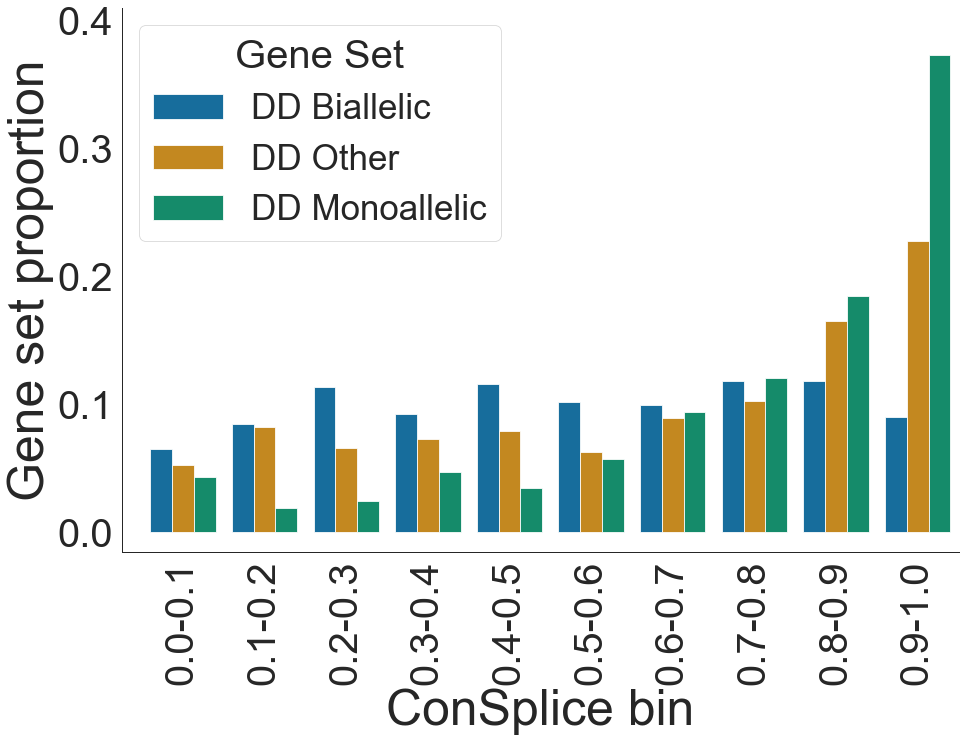

In [10]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

sns.barplot(data = normalized_dd_list_df, 
            x = "constraint_decile", 
            y = "percentage", 
            hue = "gene_list",
            hue_order = ["DD Biallelic", "DD Other", "DD Monoallelic"],
            order = deciles,
           palette = [AR_color,
                      Other_color,
                      AD_color],
            )

plt.ylabel('Gene set proportion', fontsize = 50)
plt.xlabel("ConSplice bin", fontsize = 50)

ax.tick_params(axis="x", labelsize=40, rotation = 90 )
ax.tick_params(axis="y", labelsize=40)   
plt.legend(title = "Gene Set", fontsize = 35, title_fontsize = 40)
ax.set_ylim(-0.015,0.41)
ax.set_xlim(-0.75,9.5)


plt.savefig('../figures/suppl_figure2_B.svg')